1


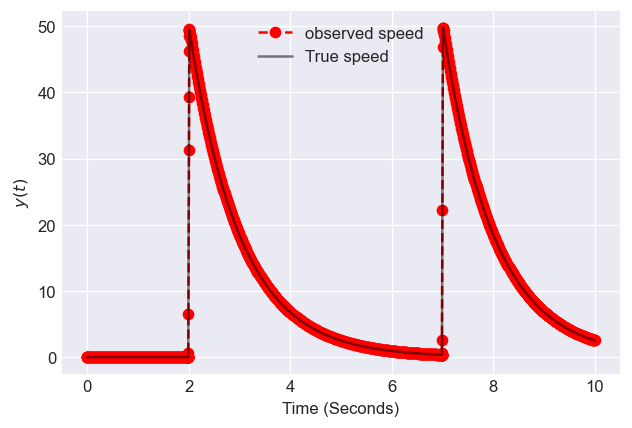

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [dose]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 37 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


plotting prior samples
plotting MCMC trace
plotting posterior samples
plotting posterior distribution


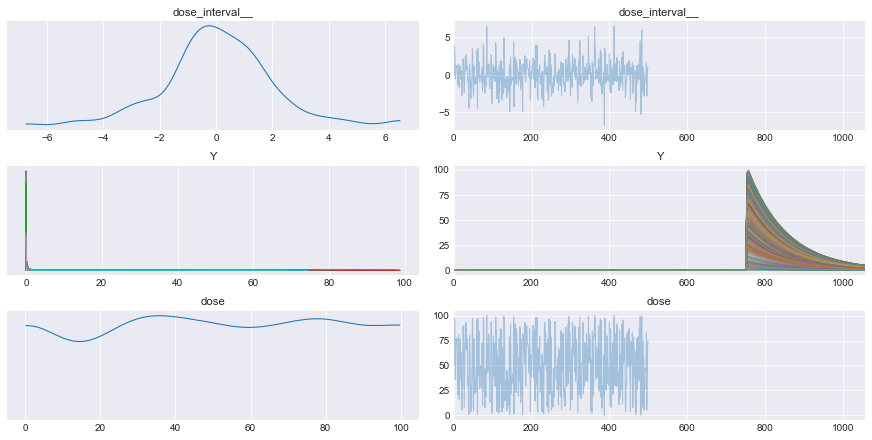

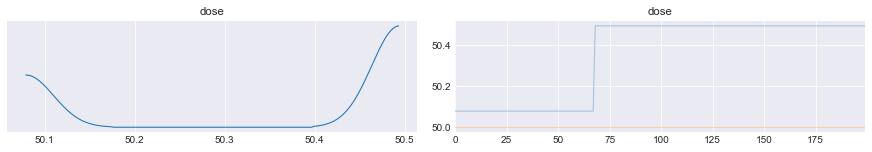

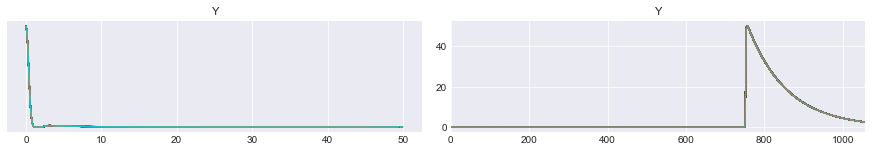

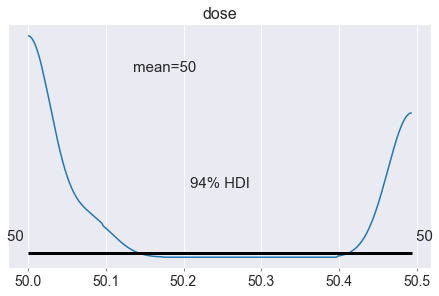

In [2]:
import numpy as np
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import arviz as az
import theano
#import numba

import warnings
warnings.filterwarnings("ignore")



plt.style.use('seaborn-darkgrid')
np.random.seed(20394)

"""
def freefall(y, t, p):
    return 2.0 * p[1] - p[0] * y[0]

#for observation
times = np.arange(0,10,0.5)
gamma, g, y0, sigma = 0.4, 9.8, -2, 2

y = odeint(freefall, t=times, y0=y0, args=tuple([[gamma, g]]))
yobs = np.random.normal(y,2)
"""

eps = 1e-2
dose_time = np.array([2, 7])
dose = 50
p=[dose]


def activation(t):
    #print(type(t))
    return (abs(dose_time[0]-t) < eps) + (abs(dose_time[1]-t) < eps)
    
def stiff_de(t, y, p):
    #print(p)
    dose = p[0]
    return [-y[0] + activation(t)*dose/(2*eps)]

#wrap the function to change the arguments order, so we can pass it to DifferentialEquation
def stiff_de_wrap(y, t, p=p):
    return stiff_de(t, y, p)[:]


#domain to simulate over
t_span = (0, 10)
#initial conditions
y0 = np.array([0])
print(y0.ndim)
#ret is a dict containing the integration of the DE
ret = solve_ivp(stiff_de, t_span, y0, method='Radau', dense_output=True, max_step=eps, args=(p,))


y = ret['y'][0]
times = ret['t']
yobs= y


fig, ax = plt.subplots(dpi=120)
plt.plot(times, yobs, label='observed speed', linestyle='dashed', marker='o', color='red')
plt.plot(times, y, label='True speed', color='k', alpha=0.5)
plt.legend()
plt.xlabel('Time (Seconds)')
plt.ylabel(r'$y(t)$');
plt.show()

yobs = ret['y'].ravel()


ode_model = DifferentialEquation(
    #func=freefall,
    func = stiff_de_wrap,
    times=times,
    n_states=1,
    n_theta=1,
    t0=0,
    
)




with pm.Model() as model:
# Specify prior distributions for soem of our model parameters
    #sigma = pm.HalfCauchy('sigma', 1)
    #sigma = pm.Uniform('sigma', 0, 0.05)
    #gamma = pm.Lognormal('gamma',0, 1)
    dose = pm.Uniform('dose', 0, 100)
    
    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=y0, theta=[dose])
    # The ode_solution has a shape of (n_times, n_states)
    #print(ode_solution.shape)
    #print(sigma.shape)
    #print(ret['y'].shape)
    Y = pm.Normal('Y', mu=ode_solution.ravel(), sigma=0.01, observed=yobs)
    
    prior = pm.sample_prior_predictive()
    
    #step = pm.Slice()
    step = pm.Metropolis()
    trace = pm.sample(200, tune=100, cores=1, step=step)
    #trace = pm.sample(2000, tune=1000, target_accept = 0.9, cores=1, step=step)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

    print("plotting prior samples")
    az.plot_trace(prior)
    print("plotting MCMC trace")
    az.plot_trace(trace)
    print("plotting posterior samples")
    az.plot_trace(posterior_predictive)
    print("plotting posterior distribution")
    az.plot_posterior(data)
    



